<a href="https://colab.research.google.com/github/rahiakela/deep-learning--from-basics-to-practice/blob/23-keras-part-1/8_callbacks_and_checkpoints.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Callbacks and Checkpoints

## Setup

In [1]:
from keras.datasets import mnist
from keras import backend as Keras_backend
from keras.utils.np_utils import to_categorical
import matplotlib.pyplot as plt

import numpy as np

from keras import backend as keras_backend
keras_backend.set_image_data_format('channels_last')

Using TensorFlow backend.


In [0]:
from keras.datasets import mnist
from keras import backend as keras_backend
from keras.models import Sequential
from keras.layers import Dense

# load MNIST data and save sizes
(X_train, y_train), (X_test, y_test) = mnist.load_data()

image_height = X_train.shape[1]
image_width = X_train.shape[2]
number_of_pixels = image_height * image_width


# convert to floating-point
X_train = keras_backend.cast_to_floatx(X_train)
X_test = keras_backend.cast_to_floatx(X_test)


# scale data to range [0, 1]
X_train /= 255.0
X_test /= 255.0


# save the original y_train and y_test
original_y_train = y_train
original_y_test = y_test

# replace label data with one-hot encoded versions
number_of_classes = 1 + max(np.append(y_train, y_test)).astype(np.int32)

# encode each list into one-hot arrays of the size we just found
y_train = to_categorical(y_train, num_classes=number_of_classes)
y_test = to_categorical(y_test, num_classes=number_of_classes)

# reshape samples to 2D grid, one line per image
X_train = X_train.reshape([X_train.shape[0], number_of_pixels])
X_test = X_test.reshape([X_test.shape[0], number_of_pixels])

def make_one_hidden_layer_model():

  # create an empty model
  model = Sequential()

  # add a fully-connected hidden layer with #nodes = #pixels
  model.add(Dense(number_of_pixels, activation='relu', input_shape=[number_of_pixels]))

  # add an output layer with softmax activation
  model.add(Dense(number_of_classes, activation='softmax'))

  return model

def compile_one_hidden_layer_model():

  # create an empty model
  model = Sequential()

  # add a fully-connected hidden layer with #nodes = #pixels
  model.add(Dense(number_of_pixels, activation='relu', input_shape=[number_of_pixels]))

  # add an output layer with softmax activation
  model.add(Dense(number_of_classes, activation='softmax'))

  # compile the model to turn it from specification to code
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

  return model

## Introduction

After each epoch it computes values such as loss and accuracy, as well
as the values we asked for in the metrics argument. It also consults
a list of callback procedures that we supply. Keras then calls each of
those procedures for us, and they can do anything we want.

We tell Keras what functions to call by handing them to fit() as the
value of an optional argument called callbacks. These callbacks can
be a combination of functions we’ve written ourselves, and functions
built into Keras.

In this section, we’ll focus on three of the callbacks provided to us by
Keras: 
* one to checkpoint (or save the weights), 
* one to control the learning rate over time, 
* and one to perform early stopping (or cease training when we appear to start overfitting).

## Checkpoints

A popular use for callbacks is to checkpoint our model during training.
This means saving out the model (or, if we prefer, just the weights)
to a file. We can save a checkpoint after every epoch if we like, but usually
we only do this after every few epochs.

Having checkpoints means that if we’re training a system that takes
hours or days, and we lose power or for any other reason the training
stops, we can pick up again by loading the most recently saved model
file.

To tell Keras to make checkpoints we’ll create a ModelCheckpoint
object, and then hand it to Keras when we call fit().

The first argument to ModelCheckpoint, which is mandatory and
unnamed, is the path to the file that will be written. This file is in the
HDF5 format, so we typically give it an extension of either .h5 or .hdf5.

In [0]:
from keras.callbacks import ModelCheckpoint

# make the model
model = compile_one_hidden_layer_model()  

# {epoch:03d} will be replaced by a 3-digit decimal number holding the current epoch.
# {val_loss:0.3f} will be replaced with a 3-digit floating-point value of the current loss
filename = 'model-weights-{epoch:02d}-{val_loss:.03f}.h5'

checkpointer = ModelCheckpoint(filename)

# call fit() to train the model, and save the history
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=256, verbose=2, callbacks=[checkpointer])

Writing out the complete model after every epoch may take up more
disk space (and computer time) than we want to use. We can cut down
on the size of the file by saving just the weights. To do this, set the
optional argument save_weights_only to True (the default is False,
so every files contains both the architecture and the weights).

We might not need even the weights written out after every epoch. We
can tell it to write out a file only periodically by setting the optional
argument period to some value (the default is 1, meaning the file is
written after every epoch). For example, if we set period to 5, then the
file is only produced every 5th epoch.

By default, the value that Keras can insert into the file name is the validation
loss, val_loss. But we can ask it to use the validation error
val_err, the training loss loss, or the training error err. We just use
the name we want in the checkpoint file.

In [0]:
# make the model
model_2 = compile_one_hidden_layer_model()  

# {epoch:03d} will be replaced by a 3-digit decimal number holding the current epoch.
# {val_loss:0.3f} will be replaced with a 3-digit floating-point value of the current loss
filename = 'model-weights-epoch-{epoch:02d}-acc-{acc:0.3f}.h5'

checkpointer = ModelCheckpoint(filename, monitor='acc', save_weights_only=True, period=10)

# call fit() to train the model, and save the history
model_2.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=256, verbose=2, callbacks=[checkpointer])

## Learning Rate

Another popular use of callbacks is to change the learning rate over
time.

Many modern optimizers automatically
adjust the learning rate adaptively (they usually have names that begin
with “Ada” for “adaptive learning rate”). But if we choose to use something
like SGD, then we’ll need to manage the learning rate ourselves.

We might start with a large learning rate,
and then shrink it either on every epoch, or in stair step fashion after
each group of some fixed number of epochs. To pull off these strategies,
or any others we might prefer, we use the built-in callback routine
named LearningRateScheduler().

The LearningRateScheduler callback is really just a little connection
function between Keras and a function that we write. The
LearningRateScheduler calls our function, and it returns the value
that our function returns. The function we write must take one argument:
an integer with the epoch number that just finished as an input
(this starts at 0). It must return a new floating-point learning rate as
an output.

We start by compiling the model with the
non-adaptive SGD optimizer. We’ve written a little scheduling routine
that we’ve called simpleSchedule(). If we wanted to use checkpointing
here as well, we could create a ModelCheckpoint object as in the
last section, and include it in the list we provide to callbacks. The
order in which the callback routines are named in this list makes no
difference.

In [0]:
from keras.callbacks import LearningRateScheduler
from keras.optimizers import SGD

# make the model
model_3 = make_one_hidden_layer_model()

sgd = SGD(lr=0.0, momentum=0.9, decay=0.0, nesterov=False)
model_3.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])

def simpleSchedule(epoch_number):
  # start at 1 and drop to 0.1
  return max(.1, 1 - (0.01 * epoch_number))

lr_scheduler = LearningRateScheduler(simpleSchedule) 

history = model_3.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=256, verbose=2, callbacks=[lr_scheduler, checkpointer])

## Early Stopping

Another popular use of callbacks is to implement early stopping.This involves watching the performance of our network and looking for signs of overfitting. When we see overfitting, we stop training.

So we stop “early” in the sense that we probably would have kept going
if not for this intervention, but in fact we’re stopping at the right time
to prevent overfitting.

The built-in routine provided by Keras implements this idea by monitoring
a statistic of our choice. When that value stops improving, it
stops training.

Early stopping is often used with checkpointing. We might tell our system
to train for a ridiculous number of epochs, like 100,000 of them,
and then go to lunch (or to sleep), leaving the computer to run, checkpointing
the model every few epochs (or saving the best one according
to some measurement). We count on the early stopping callback to stop
training when our monitored statistic stops improving. Then when we
return to the computer, we look through our saved files. Since the most
recently-written file is usually the best-trained model, that’s the one
we use from then on.

Our callback is made by creating an instance of an EarlyStopping
object. Let’s look at four of its useful options.
* First, we tell the system which value it should be watching. As usual,
we can specify the training accuracy ′acc′, training loss ′loss′, validation
accuracy ′val_acc′, or validation loss ′val_loss′. We hand
our choice to the parameter named monitor.
* Second, we provide a value to a floating-point parameter called
min_delta.In this case,
min_delta is the minimum amount of change to the monitored value
for EarlyStopping() to notice. Any change less than this amount is
ignored. By default, this value is 0, so every time the monitored value
changes, EarlyStopping() checks to see if we need to stop. That
default is usually a good place to start. We can increase this value if
we’re getting way too many files.
* Third, we provide a value to an integer called patience. As the system
watches our chosen parameter from one epoch to the next, there
might be some ranges of time where it doesn’t improve, or even gets a
little worse.The value we assign to patience tells the routine how
long the “long term” is. It’s the number of epochs to wait for things to
get better before deciding that fit() should stop training. The default
value of patience is 0, which is usually too aggressive. This is a parameter
that’s best set after a bit of experimentation to see how noisy the
results are.
* Finally, we can also set a value to verbose to have it print out a line
of text if it decides to stop training, so we can look at the output and
know that it intervened.

In [14]:
from keras.callbacks import EarlyStopping
from keras.optimizers import SGD

# make the model
model_4 = compile_one_hidden_layer_model()

early_stopper = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

history = model_4.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=256, verbose=2, 
                      callbacks=[early_stopper])

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
 - 5s - loss: 0.3034 - acc: 0.9132 - val_loss: 0.1556 - val_acc: 0.9556
Epoch 2/100
 - 4s - loss: 0.1237 - acc: 0.9641 - val_loss: 0.0998 - val_acc: 0.9708
Epoch 3/100
 - 4s - loss: 0.0807 - acc: 0.9767 - val_loss: 0.0860 - val_acc: 0.9724
Epoch 4/100
 - 4s - loss: 0.0572 - acc: 0.9837 - val_loss: 0.0702 - val_acc: 0.9781
Epoch 5/100
 - 4s - loss: 0.0435 - acc: 0.9878 - val_loss: 0.0646 - val_acc: 0.9798
Epoch 6/100
 - 4s - loss: 0.0319 - acc: 0.9916 - val_loss: 0.0645 - val_acc: 0.9800
Epoch 7/100
 - 4s - loss: 0.0240 - acc: 0.9940 - val_loss: 0.0586 - val_acc: 0.9819
Epoch 8/100
 - 4s - loss: 0.0189 - acc: 0.9955 - val_loss: 0.0595 - val_acc: 0.9813
Epoch 9/100
 - 4s - loss: 0.0140 - acc: 0.9969 - val_loss: 0.0585 - val_acc: 0.9813
Epoch 10/100
 - 4s - loss: 0.0108 - acc: 0.9980 - val_loss: 0.0559 - val_acc: 0.9828
Epoch 11/100
 - 4s - loss: 0.0082 - acc: 0.9987 - val_loss: 0.0600 - val_acc: 0.9815
Epoch 12/100
 - 4s - los

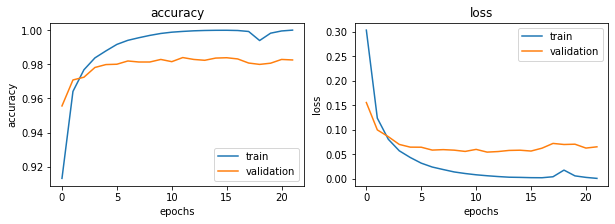

In [15]:
xs = range(len(history.history['acc']))

plt.figure(figsize=(10,3))
plt.subplot(1, 2, 1)
plt.plot(xs, history.history['acc'], label='train')
plt.plot(xs, history.history['val_acc'], label='validation')
plt.legend(loc='lower right')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('accuracy')

plt.subplot(1, 2, 2)
plt.plot(xs, history.history['loss'], label='train')
plt.plot(xs, history.history['val_loss'], label='validation')
plt.legend(loc='upper right')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('loss')

plt.show()

Early stopping is the solution we promised earlier to the problem of
picking the wrong value for epochs when calling fit(). With early
stopping in place, we can always pick a ridiculously large number for
epochs, and let the computer automatically stop training at the right
time.